In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL

Mounted at /gdrive
/gdrive/My Drive/ANNDL


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#load data
data = np.load('cleaned_dataset.npz', allow_pickle=True)


X = data["data"]
Y = data["labels"]
X.shape, Y.shape

((5004, 96, 96, 3), (5004,))

In [ ]:
X = (X/255).astype(np.float32)

#change labels in 0 for healthy and 1 for unhealthy

for i in range(Y.size):
  if Y[i] == "healthy":
    Y[i] = 0
  else:
    Y[i] = 1

X, Y

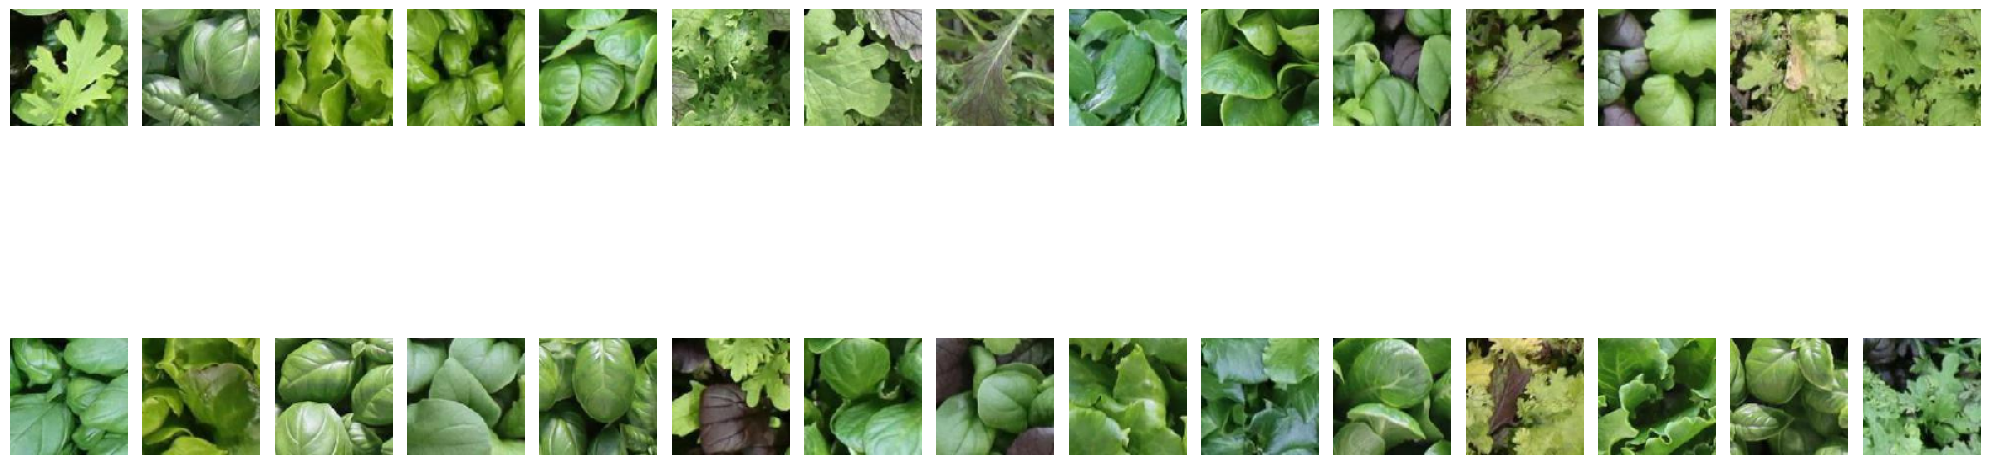

In [ ]:
# Number of images to display
num_img = 30

# Create subplots for displaying pictures
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(X[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#one-hot encoding
y = tfk.utils.to_categorical(Y,2)

# Split data into train_val and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=260, stratify=np.argmax(y,axis=1))


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (4744, 96, 96, 3), y_train shape: (4744, 2)
X_val shape: (260, 96, 96, 3), y_val shape: (260, 2)


In [ ]:
# Create ConvNeXtXLarge model with specified settings
mobile = tf.keras.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

mobile.summary()

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False


# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))

#inputs = tfkl.GaussianNoise(stddev=0.1)(inputs)

preprocessing = tf.keras.Sequential([
        tfkl.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3)),
        tfkl.RandomFlip(mode="horizontal_and_vertical", seed=None),
    ], name='preprocessing')

preprocessing = preprocessing(inputs)

# Connect ConvNeXtXLarge to the input
x = mobile(preprocessing)

#x = tfkl.Dense(128, activation='gelu')(x)

#x = tfkl.BatchNormalization(name='BatchNorm0')(x)

x = tfkl.Dense(64, activation='gelu')(x)

# Initial convolution with batch normalization and activation
x = tfkl.BatchNormalization(name='BatchNorm1')(x)

x = tfkl.Dropout(0.3)(x)
#x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)



# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(1e-4,weight_decay=5e-4), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 convnext_xlarge (Functiona  (None, 2048)              348147968 
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 BatchNorm1 (BatchNormaliza  (None, 64)                256       
 tion)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (X_val*255, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
                tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-6, mode='max')]
).history

Epoch 1/100
75/75 [==============================] - 103s 879ms/step - loss: 0.8829 - accuracy: 0.6037 - val_loss: 0.5402 - val_accuracy: 0.7077 - lr: 1.0000e-04
Epoch 2/100
75/75 [==============================] - 49s 659ms/step - loss: 0.6505 - accuracy: 0.7099 - val_loss: 0.4576 - val_accuracy: 0.7769 - lr: 1.0000e-04
Epoch 3/100
75/75 [==============================] - 48s 647ms/step - loss: 0.5901 - accuracy: 0.7411 - val_loss: 0.4094 - val_accuracy: 0.8192 - lr: 1.0000e-04
Epoch 4/100
75/75 [==============================] - 48s 634ms/step - loss: 0.5387 - accuracy: 0.7582 - val_loss: 0.3921 - val_accuracy: 0.8192 - lr: 1.0000e-04
Epoch 5/100
75/75 [==============================] - 49s 648ms/step - loss: 0.5092 - accuracy: 0.7753 - val_loss: 0.3561 - val_accuracy: 0.8462 - lr: 1.0000e-04
Epoch 6/100
75/75 [==============================] - 47s 633ms/step - loss: 0.4738 - accuracy: 0.7894 - val_loss: 0.3861 - val_accuracy: 0.8346 - lr: 1.0000e-04
Epoch 7/100
75/75 [==============

In [ ]:
# Save the best model
tl_model.save('ConvNetXL_con_aug_all')
del tl_model

**FINE TUNING**

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('ConvNetXL_con_aug_all')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 convnext_xlarge (Functiona  (None, 2048)              348147968 
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 BatchNorm1 (BatchNormaliza  (None, 64)                256       
 tion)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [ ]:
# Set all  layers as trainable
layers = ft_model.get_layer('convnext_xlarge')


# Use the supernet as feature extractor, i.e. freeze all its weigths
layers.trainable = True


# Freeze first N layers,
N = 270
for i, layer in enumerate(ft_model.get_layer('convnext_xlarge').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('convnext_xlarge').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()


# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(1e-4,weight_decay=5e-4), metrics=['accuracy'])

# Display model summary
ft_model.summary()

0 input_1 False
1 convnext_xlarge_prestem_normalization False
2 convnext_xlarge_stem False
3 convnext_xlarge_stage_0_block_0_depthwise_conv False
4 convnext_xlarge_stage_0_block_0_layernorm False
5 convnext_xlarge_stage_0_block_0_pointwise_conv_1 False
6 convnext_xlarge_stage_0_block_0_gelu False
7 convnext_xlarge_stage_0_block_0_pointwise_conv_2 False
8 convnext_xlarge_stage_0_block_0_layer_scale False
9 convnext_xlarge_stage_0_block_0_identity False
10 tf.__operators__.add False
11 convnext_xlarge_stage_0_block_1_depthwise_conv False
12 convnext_xlarge_stage_0_block_1_layernorm False
13 convnext_xlarge_stage_0_block_1_pointwise_conv_1 False
14 convnext_xlarge_stage_0_block_1_gelu False
15 convnext_xlarge_stage_0_block_1_pointwise_conv_2 False
16 convnext_xlarge_stage_0_block_1_layer_scale False
17 convnext_xlarge_stage_0_block_1_identity False
18 tf.__operators__.add_1 False
19 convnext_xlarge_stage_0_block_2_depthwise_conv False
20 convnext_xlarge_stage_0_block_2_layernorm False
21 

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train*255, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (X_val*255, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
                tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=15, min_lr=1e-5, mode='max')
]
).history

Epoch 1/100
75/75 [==============================] - 105s 1s/step - loss: 0.3023 - accuracy: 0.8739 - val_loss: 0.2659 - val_accuracy: 0.8808 - lr: 1.0000e-04
Epoch 2/100
75/75 [==============================] - 56s 749ms/step - loss: 0.2845 - accuracy: 0.8756 - val_loss: 0.3201 - val_accuracy: 0.8538 - lr: 1.0000e-04
Epoch 3/100
75/75 [==============================] - 57s 754ms/step - loss: 0.2712 - accuracy: 0.8860 - val_loss: 0.2820 - val_accuracy: 0.8846 - lr: 1.0000e-04
Epoch 4/100
75/75 [==============================] - 56s 743ms/step - loss: 0.2630 - accuracy: 0.8914 - val_loss: 0.2694 - val_accuracy: 0.8846 - lr: 1.0000e-04
Epoch 5/100
75/75 [==============================] - 56s 742ms/step - loss: 0.2462 - accuracy: 0.8965 - val_loss: 0.3042 - val_accuracy: 0.8769 - lr: 1.0000e-04
Epoch 6/100
75/75 [==============================] - 56s 744ms/step - loss: 0.2435 - accuracy: 0.8997 - val_loss: 0.3306 - val_accuracy: 0.8538 - lr: 1.0000e-04
Epoch 7/100
75/75 [=================

In [ ]:
# Save the best model
ft_model.save('ConvNetXL_con_aug_all_finetuning')
del ft_model